In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas
from helper_scripts import random_rm_trace_generator
import importlib
from matplotlib import pyplot as plt
from modules import umap_classifier

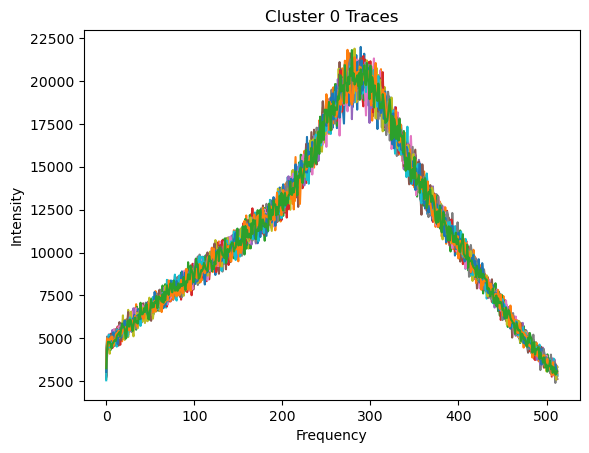

In [2]:
cluster_idx = 0
time_traces, spectra, phase, clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(100, n_clusters=4, outlier_fraction=0.05)
for i in range(100):
    if clusters[i] == cluster_idx:
        plt.plot(spectra[i], label=f'Trace {i+1}')
        plt.xlabel('Frequency')
        plt.ylabel('Intensity')
plt.title(f'Cluster {cluster_idx} Traces')
plt.show()

In [3]:
importlib.reload(umap_classifier)
importlib.reload(random_rm_trace_generator)

<module 'helper_scripts.random_rm_trace_generator' from '/cr/work/kastner/private/umap/rm_classifier/tutorials/notebooks/helper_scripts/random_rm_trace_generator.py'>

In [4]:
u = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", data_preparation={'target_data_type': "time"})

In [ ]:
d=u.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft"}, 
                 log_filter=False, max_pooling=4,avg_pooling=None,verbose=True,
                 normalization=
                 suppress_dc=True)

Adding new key input_data_type with value time to the class instance.
Overriding log_filter in data_preparation dict with value False from kwargs.
Overriding max_pooling in data_preparation dict with value 4 from kwargs.
Overriding avg_pooling in data_preparation dict with value None from kwargs.
Overriding suppress_dc in data_preparation dict with value True from kwargs.
Overriding target_data_type with value fft from data_preparation dict.
Preparing data with parameters: {'target_data_type': 'fft', 'suppress_dc': True, 'spectrum_filter': None, 'windowing': None, 'log_filter': False, 'cut_beacon_frequencies': False, 'normalization': False, 'avg_pooling': None, 'max_pooling': 4, 'denoiser_n': 20, 'denoiser_npeak': 3, 'welch_nperseg': 512, 'welch_noverlap': 0, 'welch_window': 'boxcar', 'welch_average': 'mean', 'beacon_frequencies': None, 'beacon_width': None, 'frequency_bins': None, 'sampling_frequency': 180}
Applying max pooling with pool size 4.
